In [1]:

import scipy.io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch

from torch.utils import data
from torch import nn
from sklearn.metrics import mean_squared_error as mse
from time import perf_counter as t
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

import pickle
import h5py

from models import *
from utils import *

print("GPU: ", torch.cuda.is_available())

# Initializations
seeds_init = get_seeds(20)
invivo_data, scaler_raw = load_matlab_data("./measuresInvivo.mat")
phantom_data, scaler_phantom = load_matlab_data("./measuresPhantom.mat")
make_splitset(invivo_data, phantom_data)

GPU:  True
[44358, 70603, 39148, 45506, 79478, 64963, 60127, 95167, 45113, 63575, 29865, 71747, 3123, 7670, 13739, 58413, 21155, 53744, 67568, 77727]


This is an attempt to reproduce the results in the article "Motion prediction for beating heart surgery with GRU". Five models will be train (ST-GRU, S-DNN, T-GRU, TCN & ST-LSTM) on Da-Vinci surgical robot collected stereo-endoscopic videos of beating heart in dynamic minimaly invasive surgery. This paper is multidisciplinary, thus combining prior clinical, anatomical and surgical knowledge and machine learning technics. 

# Dataset - Stereo Endoscopic Videos - Points Cooordinates

### Defining Videos Particularities

Stereo endoscopy aims to mimic 3D human vision by using two synchronised cameras or lens that are close from each other and that record the same scene, but with different angles. It optimises the depth of field perception and the precision in surgical procedures. This technic is use in medical real-time imaging for surgical interventions.

### Dataset Structure

There is two datasets to consider.


1.   Phantom dataset
2.   In Vivo Dataset



They contain 3D coordinates of four points which are APa, APb, APc and POI respectively. The auxiliary points (AP) coordinates indicate the area around the POI that is necessary for resolving the heart deformation. The spatio-temporal correlations of APs with POI of the current frames and APs and POI of previous trajectory is use for POI futur coordinates long-term prediction.


---


***{APa_depth, APa_width, APa_hight, APb_depth, APb_width, APb_hight, APc_depth, APc_width, APc_hight, POI_depth, POI_width, POI_hight}***
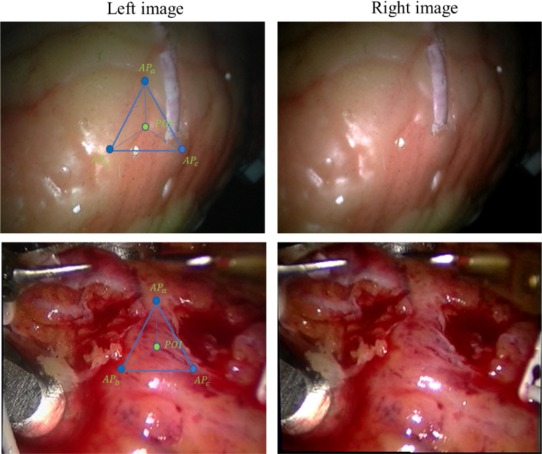

UP: Phantom

BOTTOM: In Vivo

# ST-GRU

## Training replication

### Performance training

In [ ]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)
SEED = 42
DATABASE_NAME = "ST_GRU_model_stats.h5"

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
) 

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 50 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 128 # 354
    EVAL_DIST_THR = 0.5 # in centimeters

    

    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    ST_GRU_model = ST_GRU(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    DROPOUT_RATE,
                    BATCH_FIRST,
                    )

    optimizer = torch.optim.Adam(
                            ST_GRU_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    ST_GRU_model = ST_GRU_model.cuda() if torch.cuda.is_available() else ST_GRU_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        ST_GRU_model = ST_GRU_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)
            y = y.view(-1, OUTPUT_STEPS, output_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()
            y_pred = ST_GRU_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)
        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(ST_GRU_model)


In [ ]:
# Testing
for SEED in seeds_init: # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        ST_GRU_model = models[i]
        ST_GRU_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom
        
        for start_idx in tqdm(splitsets.keys(), ascii=True, desc=f"Training for start index"): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]
                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                    
                    y_pred_test = ST_GRU_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                
            with h5py.File(DATABASE_NAME, "a") as file:

                # Make sure this new hierarchy fits with the h5 loading for graphs
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))
                    

In [ ]:
# Extract POIs coordinates
# Predicted positions average per seed, per dataset, per start_idx, per steps
model_figure_info = load_data_from_hdf5("./models_info/ST_GRU_model_stats.h5", "test_stats")

# x coords
dataset_x_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        # I will do the average of the x-coordinates for each seed, dataset for the start index 0
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][0,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_x_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }


# y coords
dataset_y_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][1,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_y_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }


#z coords
dataset_z_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][2,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_z_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

dataset_df = [dataset_x_df, dataset_y_df, dataset_z_df]
with open(f"./models_info/ST_GRU_dataset_positions.pickle", "wb") as handle:
    pickle.dump(dataset_df, handle)

### Robustess training

Test 1: Noise added to initial values in a 100-steps prediction (no cycle)

In [10]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "ST_GRU_model_noise_stats.h5"
noises = [0.0, 0.05, 0.2, 0.5, 1.0] # in centimeters

init_noise_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    noises=noises,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 50 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 128 # 354
    EVAL_DIST_THR = 0.5 # in milimeters
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    ST_GRU_model = ST_GRU(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    DROPOUT_RATE,
                    BATCH_FIRST,
                    )

    optimizer = torch.optim.Adam(
                            ST_GRU_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    ST_GRU_model = ST_GRU_model.cuda() if torch.cuda.is_available() else ST_GRU_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        ST_GRU_model = ST_GRU_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)
            y = y.view(-1, OUTPUT_STEPS, output_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()
            y_pred = ST_GRU_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)
        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(ST_GRU_model)


Training seeds: 100%|##########| 20/20 [00:37<00:00,  1.86s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        ST_GRU_model = models[i]
        ST_GRU_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for noise in noises:

            for start_idx in splitsets.keys(): # 50 starting points
                X_TEST = splitsets[start_idx][dataset_type]["x_test"]
                Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

                test_tensor_dataset = data.TensorDataset(
                                    X_TEST.type(torch.FloatTensor),
                                    Y_TEST.type(torch.FloatTensor),
                                    )
                test_loader = data.DataLoader(
                                    dataset=test_tensor_dataset,
                                    batch_size=X_TEST.size(0),
                                    shuffle=False,
                                    )

                # Test run #
                
                for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                    x_test[0] = np.add(x_test[0], noise)
                    x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                    y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                    x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                    y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                    predictions_scaled = []
                    ground_truths_scaled = []
                    losses = []
                    aucs = []
                    y_test_predictions =[]
                    y_test_ground_truth =[]

                    x_test_start = x_test[:100]
                    y_test_start  = y_test[:100]
                    
                    y_pred_test = ST_GRU_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:

                    # Make sure this new hierarchy fits with the h5 loading for graphs
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][str(noise)][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(losses))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))
                    

Test 2: Noise added at $y_{20}$ (step=621) in a continuous 100-steps cycle prediction

In [3]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "ST_GRU_model_noise_21_stats.h5"
NOISE = 1.0 # centimeter

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 50 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 128 # 354
    EVAL_DIST_THR = 0.5 # in milimeters
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    ST_GRU_model = ST_GRU(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    DROPOUT_RATE,
                    BATCH_FIRST,
                    )

    optimizer = torch.optim.Adam(
                            ST_GRU_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    ST_GRU_model = ST_GRU_model.cuda() if torch.cuda.is_available() else ST_GRU_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["weight_decay"] = WEIGHT_DECAY
        config_group.attrs["noise"] = NOISE

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        ST_GRU_model = ST_GRU_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)
            y = y.view(-1, OUTPUT_STEPS, output_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()
            y_pred = ST_GRU_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)
        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(ST_GRU_model)


Training seeds: 100%|##########| 20/20 [03:00<00:00,  9.00s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        ST_GRU_model = models[i]
        ST_GRU_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in splitsets.keys(): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test[22] = np.add(x_test[22], NOISE)
                x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]

                for i in range(X_TEST.size(0)): # 100-steps cycle predictions
                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                
                    y_pred_test = ST_GRU_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:

                    # Make sure this new hierarchy fits with the h5 loading for graphs
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(losses))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))
                    

# T-GRU

In this model, the inputs vector **x** includes only the POIs, but the temporal information is exploited.

## Model training

### Performance training - testing

In [ ]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)
SEED = 42
DATABASE_NAME = "T_GRU_model_stats.h5"
init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=42,
) 

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"][:,-3:] # Removing the APs
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 100 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 64 # 354
    EVAL_DIST_THR = 0.5 # in centimeters

    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    T_GRU_model = T_GRU(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    DROPOUT_RATE,
                    BATCH_FIRST,
                    )

    optimizer = torch.optim.Adam(
                            T_GRU_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    T_GRU_model = T_GRU_model.cuda() if torch.cuda.is_available() else T_GRU_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        T_GRU_model = T_GRU_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)
            y = y.view(-1, OUTPUT_STEPS, output_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = T_GRU_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(T_GRU_model)

In [ ]:
# Testing
for SEED in seeds_init: # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        T_GRU_model = models[i]
        T_GRU_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom
        
        for start_idx in tqdm(splitsets.keys(), ascii=True, desc=f"Training for start index"): # 50 starting points

            X_TEST = splitsets[start_idx][dataset_type]["x_test"][:,-3:] # Removing the APs
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]
                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                    
                    y_pred_test = T_GRU_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                
            with h5py.File(DATABASE_NAME, "a") as file:

                # Make sure this new hierarchy fits with the h5 loading for graphs
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

In [ ]:
# Extract POIs 3D coordinates
# predicted positions average per seed, per dataset, per start_idx, per steps
model_figure_info = load_data_from_hdf5("./models_info/T_GRU_model_stats.h5", "test_stats")
#print(model_figure_info["12189"]["in_vivo"]["0"])
# x coords
dataset_x_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        # I will do the average of the x-coordinates for each seed, dataset for the start index 0
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][0,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_x_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }
print(dataset_x_df)

# y coords
dataset_y_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][1,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_y_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }
print(dataset_y_df)

#z coords
dataset_z_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][2,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_z_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }
print(dataset_z_df)
dataset_df = [dataset_x_df, dataset_y_df, dataset_z_df]
with open(f"./models_info/T_GRU_dataset_positions.pickle", "wb") as handle:
    pickle.dump(dataset_df, handle)

### Robustess training - testing

Test 1: Noise added to initial values in a 100-steps prediction (no cycle)

In [8]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "T_GRU_model_noise_stats.h5"
noises = [0.0, 0.05, 0.2, 0.5, 1.0] # in centimeters

init_noise_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    noises=noises,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"][:,-3:] # Removing the APs
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 100 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 64 # 354
    EVAL_DIST_THR = 0.5 # in centimeter

    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    T_GRU_model = T_GRU(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    DROPOUT_RATE,
                    BATCH_FIRST,
                    )

    optimizer = torch.optim.Adam(
                            T_GRU_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    T_GRU_model = T_GRU_model.cuda() if torch.cuda.is_available() else T_GRU_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        T_GRU_model = T_GRU_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)
            y = y.view(-1, OUTPUT_STEPS, output_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()
            y_pred = T_GRU_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)
        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
        
    models.append(T_GRU_model)


Training seeds: 100%|##########| 20/20 [00:36<00:00,  1.83s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        T_GRU_model = models[i]
        T_GRU_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom
        
        for noise in noises:

            for start_idx in splitsets.keys(): # 50 starting points

                X_TEST = splitsets[start_idx][dataset_type]["x_test"][:,-3:] # Removing the APs
                Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
                
                
                test_tensor_dataset = data.TensorDataset(
                                    X_TEST.type(torch.FloatTensor),
                                    Y_TEST.type(torch.FloatTensor),
                                    )
                test_loader = data.DataLoader(
                                    dataset=test_tensor_dataset,
                                    batch_size=X_TEST.size(0),
                                    shuffle=False,
                                    )

                # Test run #
                
                for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                    x_test[0] = np.add(x_test[0], noise)
                    x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                    y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                    x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                    y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                    predictions_scaled = []
                    ground_truths_scaled = []
                    losses = []
                    aucs = []
                    y_test_predictions =[]
                    y_test_ground_truth =[]

                    x_test_start = x_test[:100]
                    y_test_start  = y_test[:100]
                    
                    y_pred_test = T_GRU_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:

                    # Make sure this new hierarchy fits with the h5 loading for graphs
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][str(noise)][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(losses))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

Test 2: Noise added at $y_{20}$ $(step=621)$ in a continuous 100-steps cycle prediction

In [4]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "T_GRU_model_noise_21_stats.h5"
NOISE = 1.0 # in centimeter

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"][:,-3:] # Removing the APs
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 100 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 64 # 354
    EVAL_DIST_THR = 0.5 # in centimeter

    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    T_GRU_model = T_GRU(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    DROPOUT_RATE,
                    BATCH_FIRST,
                    )

    optimizer = torch.optim.Adam(
                            T_GRU_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    T_GRU_model = T_GRU_model.cuda() if torch.cuda.is_available() else T_GRU_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["weight_decay"] = WEIGHT_DECAY
        config_group.attrs["noise"] = NOISE

    for epoch in tqdm(range(EPOCH), f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        T_GRU_model = T_GRU_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)
            y = y.view(-1, OUTPUT_STEPS, output_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()
            y_pred = T_GRU_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)
        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(T_GRU_model)


Training seeds: 100%|##########| 20/20 [03:09<00:00,  9.48s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        T_GRU_model = models[i]
        T_GRU_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in splitsets.keys(): # 50 starting points

            X_TEST = splitsets[start_idx][dataset_type]["x_test"][:,-3:] # Removing the APs
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
            
            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test[22] = np.add(x_test[22], NOISE)
                x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]

                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                
                    y_pred_test = T_GRU_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(losses))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

# S-DNN

In this model, the inputs vector **x** includes APs and POIs, but temporal information is **not** exploited. The next POI 3D-coords prediction is only based on the current APs and POI coords input and their learned spatial correlations.

## Model Training

### Performance training - testing

In [ ]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)
SEED = 42
DATABASE_NAME = "S_DNN_model_stats.h5"

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=42,
) 

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 200 # 100
    OUTPUT_STEPS = 1
    LAYER_1_SIZE = 512
    LAYER_2_SIZE = 256
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001 # ? might be 0.001
    SEED = SEED
    BATCH_SIZE = 128 # ?
    EVAL_DIST_THR = 0.5 # in centimeter
    BATCH_NORM = True
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)

    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )
    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        )

    S_DNN_size = [input_dim, LAYER_1_SIZE, LAYER_2_SIZE, output_dim]
    S_DNN_model = S_DNN(
                    S_DNN_size,
                    BATCH_NORM,
                    DROPOUT_RATE,
                    )

    optimizer = torch.optim.Adam(
                            S_DNN_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    S_DNN_model = S_DNN_model.cuda() if torch.cuda.is_available() else S_DNN_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["output_steps"] = OUTPUT_STEPS
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["layer_1_size"] = LAYER_1_SIZE
        config_group.attrs["layer_2_size"] = LAYER_2_SIZE
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["batch_norm"] = BATCH_NORM
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        S_DNN_model = S_DNN_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = S_DNN_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(S_DNN_model)


In [ ]:
# Testing
for SEED in seeds_init: # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        S_DNN_model = models[i]
        S_DNN_model.eval()
        
        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in tqdm(splitsets.keys(), ascii=True, desc=f"Training for start index"): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False, ####to be checked
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]

                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                    
                    y_pred_test = S_DNN_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                
            with h5py.File("S_DNN_model_stats.h5", "a") as file:
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

In [ ]:
# Extract POIs 3D coordinates
# predicted positions average per seed, per dataset, per start_idx, per steps
model_figure_info = load_data_from_hdf5("./models_info/S_DNN_model_stats.h5", "test_stats")

# x coords
dataset_x_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        # I will do the average of the x-coordinates for each seed, dataset for the start index 0
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][0,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_x_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }


# y coords
dataset_y_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][1,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_y_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }


#z coords
dataset_z_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][2,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_z_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

dataset_df = [dataset_x_df, dataset_y_df, dataset_z_df]
with open(f"S_DNN_dataset_positions.pickle", "wb") as handle:
    pickle.dump(dataset_df, handle)

### Robustess training - testing      

Test 1: Noise added to initial values in a 100-steps prediction (no cycle)

In [10]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "S_DNN_model_noise_stats.h5"
noises = [0.0, 0.05, 0.2, 0.5, 1.0] # in centimeters

init_noise_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    noises=noises,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 200 # 100
    OUTPUT_STEPS = 1
    LAYER_1_SIZE = 512
    LAYER_2_SIZE = 256
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001 # ? might be 0.001
    SEED = SEED
    BATCH_SIZE = 128 # ?
    EVAL_DIST_THR = 0.5 # in centimeter
    BATCH_NORM = True
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)

    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )
    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        )

    S_DNN_size = [input_dim, LAYER_1_SIZE, LAYER_2_SIZE, output_dim]
    S_DNN_model = S_DNN(
                    S_DNN_size,
                    BATCH_NORM,
                    DROPOUT_RATE,
                    )

    optimizer = torch.optim.Adam(
                            S_DNN_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    S_DNN_model = S_DNN_model.cuda() if torch.cuda.is_available() else S_DNN_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["output_steps"] = OUTPUT_STEPS
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["layer_1_size"] = LAYER_1_SIZE
        config_group.attrs["layer_2_size"] = LAYER_2_SIZE
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["batch_norm"] = BATCH_NORM
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        S_DNN_model = S_DNN_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = S_DNN_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)
        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(S_DNN_model)


Training seeds: 100%|##########| 20/20 [00:34<00:00,  1.71s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        S_DNN_model = models[i]
        S_DNN_model.eval()
        
        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for noise in noises: # 5 noise levels

            for start_idx in splitsets.keys(): # 50 starting points
                X_TEST = splitsets[start_idx][dataset_type]["x_test"]
                Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

                test_tensor_dataset = data.TensorDataset(
                                    X_TEST.type(torch.FloatTensor),
                                    Y_TEST.type(torch.FloatTensor),
                                    )
                test_loader = data.DataLoader(
                                    dataset=test_tensor_dataset,
                                    batch_size=X_TEST.size(0),
                                    shuffle=False,
                                    )

                # Test run #
                
                for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                    x_test[0] = np.add(x_test[0], noise)
                    
                    x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                    y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                    
                    predictions_scaled = []
                    ground_truths_scaled = []
                    
                    aucs = []
                    y_test_predictions =[]
                    y_test_ground_truth =[]

                    x_test_start = x_test
                    y_test_start  = y_test
                    
                    y_pred_test = S_DNN_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][str(noise)][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(loss_mm))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(loss_mm)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

Test 2: Noise added at $y_{20}$ $(step=621)$ in a continuous 100-steps cycle prediction

In [8]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "S_DNN_model_noise_21_stats.h5"
NOISE = 1.0 # in centimeters

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 200 # 100
    OUTPUT_STEPS = 1
    LAYER_1_SIZE = 512
    LAYER_2_SIZE = 256
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001 # ? might be 0.001
    BATCH_SIZE = 128 # ?
    EVAL_DIST_THR = 0.5 # in centimeter
    BATCH_NORM = True
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)

    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )
    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        )

    S_DNN_size = [input_dim, LAYER_1_SIZE, LAYER_2_SIZE, output_dim]
    S_DNN_model = S_DNN(
                    S_DNN_size,
                    BATCH_NORM,
                    DROPOUT_RATE,
                    )

    optimizer = torch.optim.Adam(
                            S_DNN_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    S_DNN_model = S_DNN_model.cuda() if torch.cuda.is_available() else S_DNN_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["output_steps"] = OUTPUT_STEPS
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["layer_1_size"] = LAYER_1_SIZE
        config_group.attrs["layer_2_size"] = LAYER_2_SIZE
        config_group.attrs["batch_first"] = BATCH_FIRST
        config_group.attrs["batch_norm"] = BATCH_NORM
        config_group.attrs["weight_decay"] = WEIGHT_DECAY
        config_group.attrs["noise"] = NOISE

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        S_DNN_model = S_DNN_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = S_DNN_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(S_DNN_model)


Training seeds: 100%|##########| 20/20 [02:59<00:00,  8.96s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        S_DNN_model = models[i]
        S_DNN_model.eval()
        
        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in splitsets.keys(): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
            

            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                
                x_test[22] = np.add(x_test[22], NOISE)
                
                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                
                predictions_scaled = []
                ground_truths_scaled = []
                losses=[]
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]

                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                
                    y_pred_test = S_DNN_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:

                    # Make sure this new hierarchy fits with the h5 loading for graphs
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(losses))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))



# TCN

## Model training

Baseline.

### Performance training - testing

In [46]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)
SEED = 42
DATABASE_NAME = "TCN_model_stats.h5"
init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
) 

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"][:,-3:]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]
    

    # Create sequences and specific input shape for TCN (NLC)
    sequence_length = 5
    x_sequences = create_sequences(X_TRAIN, sequence_length)
    x_sequences = x_sequences.transpose(1,2)
    y_sequences = create_sequences(Y_TRAIN, sequence_length)
    y_sequences = y_sequences.transpose(1,2)
    print(x_sequences.shape)
    X_TRAIN = x_sequences
    Y_TRAIN = y_sequences

    """------CONFIGS------"""
    EPOCH = 50 # 100
    NUM_INPUTS = 3
    NUM_CHANNELS = [512, 256, 128]
    KERNEL_SIZE = 4
    DILATIONS = [1, 2, 4]
    DILATION_RESET = 16
    DROPOUT = 0.1
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.000001 
    SEED = 42
    BATCH_SIZE = 128 # ?
    EVAL_DIST_THR = 0.5 # in centimeter
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)

    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )
    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        )

    TCN_model = TCN(
                num_inputs=NUM_INPUTS,
                num_channels=NUM_CHANNELS,
                kernel_size=KERNEL_SIZE,
                dilations=DILATIONS,
                dilation_reset=DILATION_RESET,
                dropout=DROPOUT,
                causal=False,
                use_norm='batch_norm',
                activation='selu',
                kernel_initializer='xavier_uniform',
                use_skip_connections=False,
                input_shape='NCL',
                embedding_shapes=None,
                embedding_mode='add',
                use_gate=False,
                lookahead=0,
                output_projection=None,
                output_activation=None,
            )

    optimizer = torch.optim.Adam(
                            TCN_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    TCN_model = TCN_model.cuda() if torch.cuda.is_available() else TCN_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["num_inputs"] = NUM_INPUTS
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout"] = DROPOUT
        config_group.attrs["num_channels"] = NUM_CHANNELS
        config_group.attrs["kernel_size"] = KERNEL_SIZE
        config_group.attrs["dilatations"] = DILATIONS
        config_group.attrs["dilatation_reset"] = DILATION_RESET
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        TCN_model = TCN_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = TCN_model(x)
            y_pred = y_pred[:,-3:,-1]
            y = y[:,-3:,-1]

            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()
            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)
        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(TCN_model)


torch.Size([595, 3, 5])
torch.Size([595, 3, 5])


Training for start index:   8%|8         | 4/50 [00:00<00:09,  4.63it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/katrinec/.conda/envs/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_110987/1227739937.py", line 277, in <module>
    y_pred_test = TCN_model(x_test_start)
  File "/home/katrinec/.conda/envs/venv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/katrinec/.conda/envs/venv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/katrinec/.conda/envs/venv/lib/python3.8/site-packages/pytorch_tcn/tcn.py", line 744, in forward
    x, _ = layer(
  File "/home/katrinec/.conda/envs/venv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/katrinec/.conda/envs/

In [ ]:
# Testing
for SEED in seeds_init: # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        TCN_model = models[i]
        TCN_model.eval()
        
        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in tqdm(splitsets.keys(), ascii=True, desc=f"Training for start index"): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"][:,-3:]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

            sequence_length = 5
            
            x_sequences = create_sequences(X_TEST, sequence_length)
            x_sequences = x_sequences.transpose(1,2)
            y_sequences = create_sequences(Y_TEST, sequence_length)
            y_sequences = y_sequences.transpose(1,2)

            X_TEST = x_sequences
            Y_TEST = y_sequences

            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                # x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                # y_test = y_test.view(-1, OUTPUT_STEPS, output_dim)

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]
                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                    
                    y_pred_test = TCN_model(x_test_start)
                    y_pred_test = y_pred_test[:,-3:,-1]
                    y_test_start = y_test_start[:,-3:,-1]
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)
                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

In [ ]:
# Extract POIs 3D coordinates
model_figure_info = load_data_from_hdf5("./models_info/TCN_model_stats.h5", "test_stats")
# x coords
dataset_x_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        # I will do the average of the x-coordinates for each seed, dataset for the start index 0
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][0,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_x_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

# y coords
dataset_y_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][1,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_y_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

#z coords
dataset_z_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][2,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_z_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }
    
dataset_df = [dataset_x_df, dataset_y_df, dataset_z_df]
with open(f"./models_info/TCN_dataset_positions.pickle", "wb") as handle:
    pickle.dump(dataset_df, handle)

### Robustess training - testing

Test 1: Noise added to initial values in a 100-steps prediction (no cycle)

In [6]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "TCN_model_noise_stats.h5"
noises = [0.0, 0.05, 0.2, 0.5, 1.0] # in centimeters

init_noise_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    noises=noises,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"][:,-3:]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]
    

    # Create sequences and specific input shape for TCN (NLC)
    sequence_length = 5
    x_sequences = create_sequences(X_TRAIN, sequence_length)
    x_sequences = x_sequences.transpose(1,2)
    y_sequences = create_sequences(Y_TRAIN, sequence_length)
    y_sequences = y_sequences.transpose(1,2)
    
    X_TRAIN = x_sequences
    Y_TRAIN = y_sequences

    """------CONFIGS------"""
    EPOCH = 50 # 100
    NUM_INPUTS = 3
    NUM_CHANNELS = [512, 256, 128]
    KERNEL_SIZE = 4
    DILATIONS = [1, 2, 4]
    DILATION_RESET = 16
    DROPOUT = 0.1
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.000001 
    SEED = 42
    BATCH_SIZE = 128 # ?
    EVAL_DIST_THR = 0.5 # in centimeters
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)

    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )
    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        )

    TCN_model = TCN(
                num_inputs=NUM_INPUTS,
                num_channels=NUM_CHANNELS,
                kernel_size=KERNEL_SIZE,
                dilations=DILATIONS,
                dilation_reset=DILATION_RESET,
                dropout=DROPOUT,
                causal=False,
                use_norm='batch_norm',
                activation='selu',
                kernel_initializer='xavier_uniform',
                use_skip_connections=False,
                input_shape='NCL',
                embedding_shapes=None,
                embedding_mode='add',
                use_gate=False,
                lookahead=0,
                output_projection=None,
                output_activation=None,
            )

    optimizer = torch.optim.Adam(
                            TCN_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    TCN_model = TCN_model.cuda() if torch.cuda.is_available() else TCN_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["num_inputs"] = NUM_INPUTS
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout"] = DROPOUT
        config_group.attrs["num_channels"] = NUM_CHANNELS
        config_group.attrs["kernel_size"] = KERNEL_SIZE
        config_group.attrs["dilatations"] = DILATIONS
        config_group.attrs["dilatation_reset"] = DILATION_RESET
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        TCN_model = TCN_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):


            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = TCN_model(x)
            y_pred = y_pred[:,-3:,-1]
            y = y[:,-3:,-1]
            optimizer.zero_grad()
            
            loss = criterion(y_pred, y)
            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()

            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)
        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(TCN_model)


Training seeds: 100%|##########| 20/20 [00:50<00:00,  2.53s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        TCN_model = models[i]
        TCN_model.eval()
        
        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for noise in noises: # 5 noise levels

            for start_idx in splitsets.keys(): # 50 starting points
                X_TEST = splitsets[start_idx][dataset_type]["x_test"][:,-3:]
                Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
                
                sequence_length = 5
                
                x_sequences = create_sequences(X_TEST, sequence_length)
                x_sequences = x_sequences.transpose(1,2)
                y_sequences = create_sequences(Y_TEST, sequence_length)
                y_sequences = y_sequences.transpose(1,2)

                X_TEST = x_sequences
                Y_TEST = y_sequences

                test_tensor_dataset = data.TensorDataset(
                                    X_TEST.type(torch.FloatTensor),
                                    Y_TEST.type(torch.FloatTensor),
                                    )
                test_loader = data.DataLoader(
                                    dataset=test_tensor_dataset,
                                    batch_size=X_TEST.size(0),
                                    shuffle=False,
                                )

                # Test run #
                
                for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                    x_test[0] = np.add(x_test[0], noise)
                    x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                    y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                    predictions_scaled = []
                    ground_truths_scaled = []
                    losses = []
                    aucs = []
                    y_test_predictions =[]
                    y_test_ground_truth =[]

                    x_test_start = x_test
                    y_test_start  = y_test
                    
                    y_pred_test = TCN_model(x_test_start)
                    y_pred_test = y_pred_test[:,-3:,-1]
                    y_test_start = y_test_start[:,-3:,-1]
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)
                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
                with h5py.File(DATABASE_NAME, "a") as file:
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][str(noise)][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(losses))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

Test 2: Noise added at $y_{20}$ $(step=621)$ in a continuous 100-steps cycle prediction

In [19]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "TCN_model_noise_21_stats.h5"
NOISE = 1.0 # in centimeters

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"][:,-3:]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]
    

    # Create sequences and specific input shape for TCN (NLC)
    sequence_length = 5
    x_sequences = create_sequences(X_TRAIN, sequence_length)
    x_sequences = x_sequences.transpose(1,2)
    y_sequences = create_sequences(Y_TRAIN, sequence_length)
    y_sequences = y_sequences.transpose(1,2)
    
    X_TRAIN = x_sequences
    Y_TRAIN = y_sequences

    """------CONFIGS------"""
    EPOCH = 50 # 100
    NUM_INPUTS = 3
    NUM_CHANNELS = [512, 256, 128]
    KERNEL_SIZE = 4
    DILATIONS = [1, 2, 4]
    DILATION_RESET = 16
    DROPOUT = 0.1
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.000001 
    SEED = 42
    BATCH_SIZE = 128 # ?
    EVAL_DIST_THR = 0.5 # in centimeters
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)

    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )
    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        )

    TCN_model = TCN(
                num_inputs=NUM_INPUTS,
                num_channels=NUM_CHANNELS,
                kernel_size=KERNEL_SIZE,
                dilations=DILATIONS,
                dilation_reset=DILATION_RESET,
                dropout=DROPOUT,
                causal=False,
                use_norm='batch_norm',
                activation='selu',
                kernel_initializer='xavier_uniform',
                use_skip_connections=False,
                input_shape='NCL',
                embedding_shapes=None,
                embedding_mode='add',
                use_gate=False,
                lookahead=0,
                output_projection=None,
                output_activation=None,
            )

    optimizer = torch.optim.Adam(
                            TCN_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    TCN_model = TCN_model.cuda() if torch.cuda.is_available() else TCN_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["num_inputs"] = NUM_INPUTS
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout"] = DROPOUT
        config_group.attrs["num_channels"] = NUM_CHANNELS
        config_group.attrs["kernel_size"] = KERNEL_SIZE
        config_group.attrs["dilatations"] = DILATIONS
        config_group.attrs["dilatation_reset"] = DILATION_RESET
        config_group.attrs["weight_decay"] = WEIGHT_DECAY
        config_group.attrs["noise"] = NOISE

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        TCN_model = TCN_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = TCN_model(x)
            y_pred = y_pred[:,-3:,-1]
            y = y[:,-3:,-1]
            optimizer.zero_grad()
            
            loss = criterion(y_pred, y)
            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()
            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)

        epoch_auc = epoch_auc / (batch_idx + 1)

        train_info(epoch, start_time, current_time, previous_time, mean_loss)
        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(TCN_model)


Training seeds: 100%|##########| 20/20 [06:11<00:00, 18.56s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        TCN_model = models[i]
        TCN_model.eval()
        
        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in splitsets.keys(): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"][:,-3:]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
            
            sequence_length = 5
            
            x_sequences = create_sequences(X_TEST, sequence_length)
            x_sequences = x_sequences.transpose(1,2)
            y_sequences = create_sequences(Y_TEST, sequence_length)
            y_sequences = y_sequences.transpose(1,2)

            X_TEST = x_sequences
            Y_TEST = y_sequences

            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=X_TEST.size(0),
                                shuffle=False,
                            )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test[22] = np.add(x_test[22], NOISE)
                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]
                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                
                    y_pred_test = TCN_model(x_test_start)
                    y_pred_test = y_pred_test[:,-3:,-1]
                    y_test_start = y_test_start[:,-3:,-1]
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)

                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])

                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)
                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)
                    
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))

# ST-LSTM

## Model training

### Preformance training - testing

In [ ]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)
SEED = 42
DATABASE_NAME = "ST_LSTM_model_stats.h5"
init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
) 
models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 50 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 128 # 354
    EVAL_DIST_THR = 0.5 # in centimeter
    VERSION = f"{SEED}_{dataset_type}_{start_idx}"
    FILENAME = "replicate"

    

    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    ST_LSTM_model = ST_LSTM(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    )

    optimizer = torch.optim.Adam(
                            ST_LSTM_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    ST_LSTM_model = ST_LSTM_model.cuda() if torch.cuda.is_available() else ST_LSTM_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["weight_decay"] = WEIGHT_DECAY
        config_group.attrs["version"] = VERSION

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):

        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        ST_LSTM_model = ST_LSTM_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = ST_LSTM_model(x)

            optimizer.zero_grad()
            loss = criterion(y_pred, y)

            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()
            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)
        epoch_auc = epoch_auc / (batch_idx + 1)
        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(ST_LSTM_model)


In [ ]:
# Testing
for SEED in seeds_init: # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets
        ST_LSTM_model = models[i]
        ST_LSTM_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom
        
        for start_idx in tqdm(splitsets.keys(), ascii=True, desc=f"Training for start index"): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]
            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=Y_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)

                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]

                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                    y_pred_test = ST_LSTM_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)
                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])
                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))
                    

In [ ]:
# Extract POIs 3D coordinates
model_figure_info = load_data_from_hdf5("./models_info/ST_LSTM_model_stats.h5", "test_stats")

# x coords
dataset_x_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        # I will do the average of the x-coordinates for each seed, dataset for the start index 0
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        
        position_dict[key] = position_dict[key][0,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_x_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

# y coords
dataset_y_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][1,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_y_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

#z coords
dataset_z_df = {}
for dataset in ["in_vivo", "phantom"]:
    position_dict = {}
    for seed in list(model_figure_info.keys()):
        key = f"{dataset}_{seed}_{0}"
        position_dict[key] = model_figure_info[seed][dataset][str(0)]["preds_test_scaled"].T
        position_dict[key] = position_dict[key][2,:]
    position_df = pd.DataFrame(position_dict)
    position_mean = pd.DataFrame(position_df.mean(axis=1), columns=[dataset])
    position_max = pd.DataFrame(position_df.max(axis=1), columns=[dataset])
    position_min = pd.DataFrame(position_df.min(axis=1), columns=[dataset])
    position_std = pd.DataFrame(position_df.std(axis=1), columns=[dataset])
    dataset_z_df[dataset] = {
        "position_mean": position_mean,
        "position_max": position_max,
        "position_min": position_min,
        "position_std": position_std,
        }

dataset_df = [dataset_x_df, dataset_y_df, dataset_z_df]
with open(f"./models_info/ST_LSTM_dataset_positions.pickle", "wb") as handle:
    pickle.dump(dataset_df, handle)

### Robustess training - testing

Test 1: Noise added to initial values in a 100-steps prediction (no cycle)

In [7]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "ST_LSTM_model_noise_stats.h5"
noises = [0.0, 0.05, 0.2, 0.5, 1.0] # in centimeters

init_noise_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    noises=noises,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 50 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 128 # 354
    EVAL_DIST_THR = 0.5 # in centimeter
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    ST_LSTM_model = ST_LSTM(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    )

    optimizer = torch.optim.Adam(
                            ST_LSTM_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    ST_LSTM_model = ST_LSTM_model.cuda() if torch.cuda.is_available() else ST_LSTM_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["weight_decay"] = WEIGHT_DECAY

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))

        ST_LSTM_model = ST_LSTM_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = ST_LSTM_model(x)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()
            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc
            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)
        epoch_auc = epoch_auc / (batch_idx + 1)
        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(ST_LSTM_model)


Training seeds: 100%|##########| 20/20 [00:37<00:00,  1.89s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets

        ST_LSTM_model = models[i]
        ST_LSTM_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for noise in noises: # 5 noise levels

            for start_idx in splitsets.keys(): # 50 starting points
                X_TEST = splitsets[start_idx][dataset_type]["x_test"]
                Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

                test_tensor_dataset = data.TensorDataset(
                                    X_TEST.type(torch.FloatTensor),
                                    Y_TEST.type(torch.FloatTensor),
                                    )
                test_loader = data.DataLoader(
                                    dataset=test_tensor_dataset,
                                    batch_size=Y_TEST.size(0),
                                    shuffle=False,
                                    )

                # Test run #
                
                for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                    x_test[0] = np.add(x_test[0], noise)
                    x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                    
                    x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                    y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                    predictions_scaled = []
                    ground_truths_scaled = []
                    losses = []
                    aucs = []
                    y_test_predictions =[]
                    y_test_ground_truth =[]

                    x_test_start = x_test[:100]
                    y_test_start  = y_test[:100]
                    y_pred_test = ST_LSTM_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)
                    
                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])
                    
                    loss_mm = mse(ground_truths_test, preds_test)

                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)

                with h5py.File(DATABASE_NAME, "a") as file:
                    train_group = file["test_stats"]
                    config_group = train_group[str(SEED)][dataset_type][str(noise)][start_idx]
                    config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                    config_group.create_dataset("MSE_loss", data=np.array(loss_mm))
                    config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(loss_mm)))
                    config_group.create_dataset("test_auc", data=np.array(aucs))
                    config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                    config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                    config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                    config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))
                        


Test 2: Noise added at $y_{20}$ $(step=621)$ in a continuous 100-steps cycle prediction

In [17]:
with open(f"datasets_split.pickle", "rb") as handle:
    splitsets=pickle.load(handle)

SEED = 42
DATABASE_NAME = "ST_LSTM_model_noise_21_stats.h5"
NOISE = 1.0 # in centimeters

init_model_hdf5(
    model_name=DATABASE_NAME,
    seeds_test=seeds_init,
    splitsets=splitsets,
    training_seed=SEED,
)

models = []
for dataset_type in ["in_vivo", "phantom"]:

    if dataset_type == "in_vivo":
        data_scaler = scaler_raw
    else: data_scaler = scaler_phantom

    X_TRAIN = splitsets["0"][dataset_type]["x_train"]
    Y_TRAIN = splitsets["0"][dataset_type]["y_train"]

    """------CONFIGS------"""
    EPOCH = 50 # 100
    OUTPUT_STEPS = 1
    LEARNING_RATE = 0.01
    DROPOUT_RATE = 0.1
    NB_LAYERS = 2
    BATCH_FIRST = True
    WEIGHT_DECAY = 0.000001
    SEED = 42

    HIDDEN_SIZE = 256 # 600
    BATCH_SIZE = 128 # 354
    EVAL_DIST_THR = 0.5 # in centimeter
    """--------------------"""

    #-----------------------------#

    """--------INITIALISATIONS---------"""
    train_info = training_info()
    test_info = training_info()

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_TRAIN.size(1)
    output_dim = Y_TRAIN.size(1)


    tensor_dataset = data.TensorDataset(
        X_TRAIN.type(torch.FloatTensor),
        Y_TRAIN.type(torch.FloatTensor),
        )

    train_loader = data.DataLoader(
        dataset=tensor_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        )

    

    ST_LSTM_model = ST_LSTM(
                    input_dim,
                    HIDDEN_SIZE,
                    NB_LAYERS,
                    )

    optimizer = torch.optim.Adam(
                            ST_LSTM_model.parameters(),
                            lr = LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY,
                            )

    criterion = nn.MSELoss()

    ST_LSTM_model = ST_LSTM_model.cuda() if torch.cuda.is_available() else ST_LSTM_model.cpu()

    start_time = t()
    previous_time = start_time
    """--------------------------------"""

    #----------TRAINING-------------#
    with h5py.File(DATABASE_NAME, "a") as file:
        train_group = file["configs"]
        config_group = train_group[str(SEED)][dataset_type]
        config_group.attrs["epoch"] = EPOCH
        config_group.attrs["distance_thr_mm"] = EVAL_DIST_THR
        config_group.attrs["learning_rate"] = LEARNING_RATE
        config_group.attrs["hidden_size"] = HIDDEN_SIZE
        config_group.attrs["batch_size"] = BATCH_SIZE
        config_group.attrs["dropout_rate"] = DROPOUT_RATE
        config_group.attrs["nb_layers"] = NB_LAYERS
        config_group.attrs["weight_decay"] = WEIGHT_DECAY
        config_group.attrs["noise"] = NOISE

    for epoch in tqdm(range(EPOCH), desc=f"Training epoch {epoch} on {dataset_type} dataset"):
        with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type]
                config_group.create_group(str(epoch))
        ST_LSTM_model = ST_LSTM_model.train()
        loss_value = 0
        epoch_auc = 0.0

        for batch_idx, (x, y) in enumerate(train_loader):
            
            x = x.view(-1, OUTPUT_STEPS, input_dim)

            x = x.cuda() if torch.cuda.is_available() else x.cpu()
            y = y.cuda() if torch.cuda.is_available() else y.cpu()

            y_pred = ST_LSTM_model(x)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss = loss.cuda() if torch.cuda.is_available() else loss.cpu()
            loss.backward()
            optimizer.step()

            loss_value += loss.item()

            preds, ground_truths = retrieve_raw_data(y_pred, y, data_scaler)
            
            l2_sim = l2_similarity(
                                    preds=preds,
                                    ground_truths=ground_truths,
                                    threshold=EVAL_DIST_THR,
                                    )
            batch_auc = accuracy(l2_sim)
            epoch_auc += batch_auc

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["batch_stats"]
                config_group = train_group[str(SEED)][dataset_type][str(epoch)]
                config_group.create_group(str(batch_idx))
                config_group[str(batch_idx)].attrs["epoch"] = epoch
                config_group[str(batch_idx)].attrs["batch_idx"] = batch_idx
                config_group[str(batch_idx)].attrs["batch_auc"] = batch_auc
                
            current_time = t()

        mean_loss = loss_value/(batch_idx+1)
        epoch_auc = epoch_auc / (batch_idx + 1)
        train_info(epoch, start_time, current_time, previous_time, mean_loss)

        with h5py.File(DATABASE_NAME, "a") as file:
            train_group = file["epoch_stats"]
            config_group = train_group[str(SEED)][dataset_type]
            config_group.create_group(str(epoch))
            config_group[str(epoch)].attrs["epoch"] = epoch
            config_group[str(epoch)].attrs["epoch_auc"] = epoch_auc
            config_group[str(epoch)].attrs["epoch_loss"] = mean_loss
            config_group[str(epoch)].attrs["epoch_time"] = train_info.dict_info["epoch_time"]
            config_group[str(epoch)].attrs["total_time"] = train_info.dict_info["total_time"]
            config_group[str(epoch)].attrs["MSE_loss"] = train_info.dict_info["MSE_loss"]
            config_group[str(epoch)].attrs["RMSE_loss"] = train_info.dict_info["RMSE_loss"]

        previous_time = current_time
    models.append(ST_LSTM_model)


Training seeds: 100%|##########| 20/20 [03:07<00:00,  9.39s/it]


In [ ]:
# Testing
for SEED in tqdm(seeds_init, ascii=True, desc=f"Training seeds"): # 20 random seeds
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    for i, dataset_type in enumerate(["in_vivo", "phantom"]): # 2 datasets

        ST_LSTM_model = models[i]
        ST_LSTM_model.eval()

        if dataset_type == "in_vivo":
            data_scaler = scaler_raw
        else: data_scaler = scaler_phantom

        for start_idx in splitsets.keys(): # 50 starting points
            X_TEST = splitsets[start_idx][dataset_type]["x_test"]
            Y_TEST = splitsets[start_idx][dataset_type]["y_test"]

            test_tensor_dataset = data.TensorDataset(
                                X_TEST.type(torch.FloatTensor),
                                Y_TEST.type(torch.FloatTensor),
                                )
            test_loader = data.DataLoader(
                                dataset=test_tensor_dataset,
                                batch_size=Y_TEST.size(0),
                                shuffle=False,
                                )

            # Test run #
            
            for batch_idx, (x_test, y_test) in enumerate(test_loader): # one batch
                x_test[21] = np.add(x_test[21], NOISE)
                x_test = x_test.view(-1, OUTPUT_STEPS, input_dim)
                
                x_test = x_test.cuda() if torch.cuda.is_available() else x_test.cpu()
                y_test = y_test.cuda() if torch.cuda.is_available() else y_test.cpu()
                predictions_scaled = []
                ground_truths_scaled = []
                losses = []
                aucs = []
                y_test_predictions =[]
                y_test_ground_truth =[]

                for i in range(X_TEST.size(0)): # 100-steps cycle predictions

                    x_test_start = x_test[:i+1]
                    y_test_start  = y_test[:i+1]
                    y_pred_test = ST_LSTM_model(x_test_start)
                    
                    loss_test = criterion(y_pred_test, y_test_start)
                    loss_test = loss_test.item()

                    preds_test, ground_truths_test = retrieve_raw_data(y_pred_test, y_test_start, data_scaler)
                    
                    predictions_scaled.append(preds_test[-1])
                    ground_truths_scaled.append(ground_truths_test[-1])
                    
                    loss_mm = mse(ground_truths_test, preds_test)
                    losses.append(loss_mm)
                    l2_sim = l2_similarity(
                                            preds=preds_test,
                                            ground_truths=ground_truths_test,
                                            threshold=EVAL_DIST_THR,
                                            )
                    test_auc = accuracy(l2_sim)
                    aucs.append(test_auc)
                    y_pred_tested= y_pred_test.cpu().detach().numpy()
                    y_test_predictions.append(np.squeeze(y_pred_tested[-1,:]))
                    y_test_tested = y_test.cpu().detach().numpy()  
                    y_test_ground_truth.append(np.squeeze(y_test_tested[-1,:]))
                    test_info(epoch, start_time, current_time, previous_time, loss_test)

            with h5py.File(DATABASE_NAME, "a") as file:
                train_group = file["test_stats"]
                config_group = train_group[str(SEED)][dataset_type][start_idx]
                config_group.create_dataset("total_time", data=np.array(test_info.dict_info["total_time"]))
                config_group.create_dataset("MSE_loss", data=np.array(losses))
                config_group.create_dataset("RMSE_loss", data=np.array(np.sqrt(losses)))
                config_group.create_dataset("test_auc", data=np.array(aucs))
                config_group.create_dataset("y_preds", data=np.array(y_test_predictions))
                config_group.create_dataset("ys", data=np.array(y_test_ground_truth))
                config_group.create_dataset("preds_test_scaled", data=np.array(predictions_scaled))
                config_group.create_dataset("ground_truths_test_scaled", data=np.array(ground_truths_scaled))
                    

# Figures Replication 

Load Positions

In [39]:
# Load T-GRU positions
with open(f"./models_info/T_GRU_dataset_positions.pickle", "rb") as handle:
    T_GRU_positions = pickle.load(handle)

dataset_positions_T = []
for dataset in ["in_vivo", "phantom"]:
    T_x_mean = T_GRU_positions[0][dataset]["position_mean"]
    T_y_mean = T_GRU_positions[1][dataset]["position_mean"]
    T_z_mean = T_GRU_positions[2][dataset]["position_mean"]
    dataset_positions_T.append([T_x_mean, T_y_mean, T_z_mean])

# Load S-DNN positions
with open(f"./models_info/S_DNN_dataset_positions.pickle", "rb") as handle:
    S_DNN_positions = pickle.load(handle)

dataset_positions_S = []
for dataset in ["in_vivo", "phantom"]:
    S_x_mean = S_DNN_positions[0][dataset]["position_mean"]
    S_y_mean = S_DNN_positions[1][dataset]["position_mean"]
    S_z_mean = S_DNN_positions[2][dataset]["position_mean"]
    dataset_positions_S.append([S_x_mean, S_y_mean, S_z_mean])

# Load ST-GRU positions
with open(f"./models_info/ST_GRU_dataset_positions.pickle", "rb") as handle:
    ST_GRU_positions = pickle.load(handle)

dataset_positions_ST = []
for dataset in ["in_vivo", "phantom"]:
    ST_x_mean = ST_GRU_positions[0][dataset]["position_mean"]
    ST_y_mean = ST_GRU_positions[1][dataset]["position_mean"]
    ST_z_mean = ST_GRU_positions[2][dataset]["position_mean"]
    dataset_positions_ST.append([ST_x_mean, ST_y_mean, ST_z_mean])

In [25]:
# ground truth positions
in_vivo_dataset = np.array(scipy.io.loadmat("./measuresInvivo.mat")["measures"].T[600:700,-3:].T)
phantom_dataset = np.array(scipy.io.loadmat("./measuresPhantom.mat")["measures"].T[600:700,-3:].T)


(3, 100)


Let $\ell(n)$ be given by

$
\ell(n) = \frac{1}{50} \sum_{K=600}^{649} \left\| \hat{x}^{\text{POI}}_{K+n}- x^{\text{POI}}_{K+n}\right\|^2_2
$

Let $\overline{\ell}(n)$ be the average MSE over 20 tests. The root mean square error (RMSE) for a total of $50 \times 20 \times 100$ points is calculated as an overall accuracy index for continuous prediction,

$
RMSE = \sqrt{\frac{1}{100} \sum^{100}_{n=1} \overline{\ell}(n)}
$

Load MSE and RMSE loss

In [ ]:
model_paths = [
    "models_info/T_GRU_model_stats.h5", 
    "models_info/S_DNN_model_stats.h5", 
    "models_info/ST_GRU_model_stats.h5",
    "models_info/TCN_model_stats.h5",
    "models_info/ST_LSTM_model_stats.h5",
    ]
model_info_array = np.ndarray(shape=(len(model_paths), 2, 2, 20, 50, 100, 1))
mean_info_array = np.ndarray(shape=(len(model_paths), 2, 2))
for i, path in enumerate(model_paths):
    print(path)
    model_figure_info = load_data_from_hdf5(path, "test_stats")
    #print(model_figure_info)
    for j, metric in enumerate(["MSE_loss", "RMSE_loss"]):
        for l, dataset in enumerate(["phantom", "in_vivo"]):
            for n, seed in enumerate(list(model_figure_info.keys())):
                for m, start_idx in enumerate(range(50)):
                    for k in range(100):
                        if (i == 3 and k > 95):
                            model_info_array[i, j, l, n, m, k, 0] = model_figure_info[seed][dataset][str(start_idx)][metric][-1]
                        else:
                            model_info_array[i, j, l, n, m, k, 0] = model_figure_info[seed][dataset][str(start_idx)][metric][k]
                        
mean_info_array = np.mean(model_info_array[:,:,:,:,:,:,0], axis=(3, 4))

### Fig. 4. The motion curves of 100-steps cycle prediction

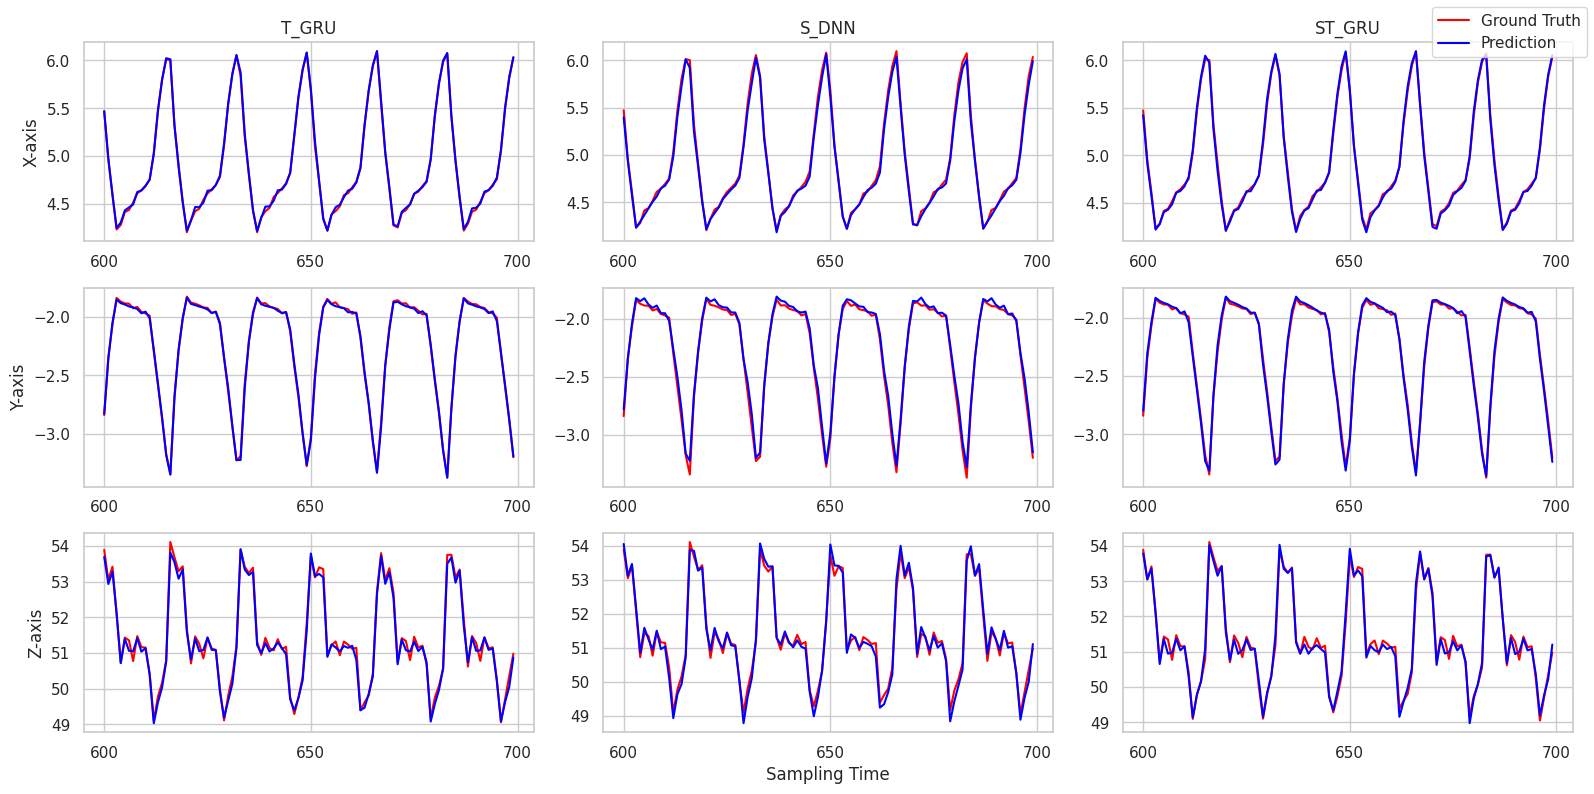

In [70]:
# T-GRU - S-DNN - ST-GRU => x - y - z / steps

sns.set_theme(style="whitegrid")

ground_truths_test = phantom_dataset

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))

axes[0,0].plot(ground_truths_test[0,:], color = "red")
axes[0,0].plot(dataset_positions_T[1][0], color = "blue")
axes[0,0].set_title("T_GRU")
axes[0,0].set_ylabel("X-axis")

axes[0,1].plot(ground_truths_test[0,:], color = "red")
axes[0,1].plot(dataset_positions_S[1][0], color = "blue")
axes[0,1].set_title("S_DNN")

axes[0,2].plot(ground_truths_test[0,:], color = "red", label="Ground Truth")
axes[0,2].plot(dataset_positions_ST[1][0], color = "blue", label="Prediction")
axes[0,2].set_title("ST_GRU")

axes[1,0].plot(ground_truths_test[1,:], color = "red")
axes[1,0].plot(dataset_positions_T[1][1], color = "blue")
axes[1,0].set_ylabel("Y-axis")

axes[1,1].plot(ground_truths_test[1,:], color = "red")
axes[1,1].plot(dataset_positions_S[1][1], color = "blue")

axes[1,2].plot(ground_truths_test[1,:], color = "red")
axes[1,2].plot(dataset_positions_ST[1][1], color = "blue")

axes[2,0].plot(ground_truths_test[2,:], color = "red")
axes[2,0].plot(dataset_positions_T[1][2], color = "blue")
axes[2,0].set_ylabel("Z-axis")  

axes[2,1].plot(ground_truths_test[2,:], color = "red")
axes[2,1].plot(dataset_positions_S[1][2], color = "blue")
axes[2,1].set_xlabel("Sampling Time")

axes[2,2].plot(ground_truths_test[2,:], color = "red")
axes[2,2].plot(dataset_positions_ST[1][2], color = "blue")

for ax in axes.flat:
    ax.set_xticks(ticks=[0, 50, 100],labels=[600, 650, 700])

lines_labels = [axes[0,2].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines[:2], labels[:2], loc='upper right')

plt.tight_layout()


### Fig. 5. Average MSE curves on $\overline{l}(n)$ phantom and in vivo dataset

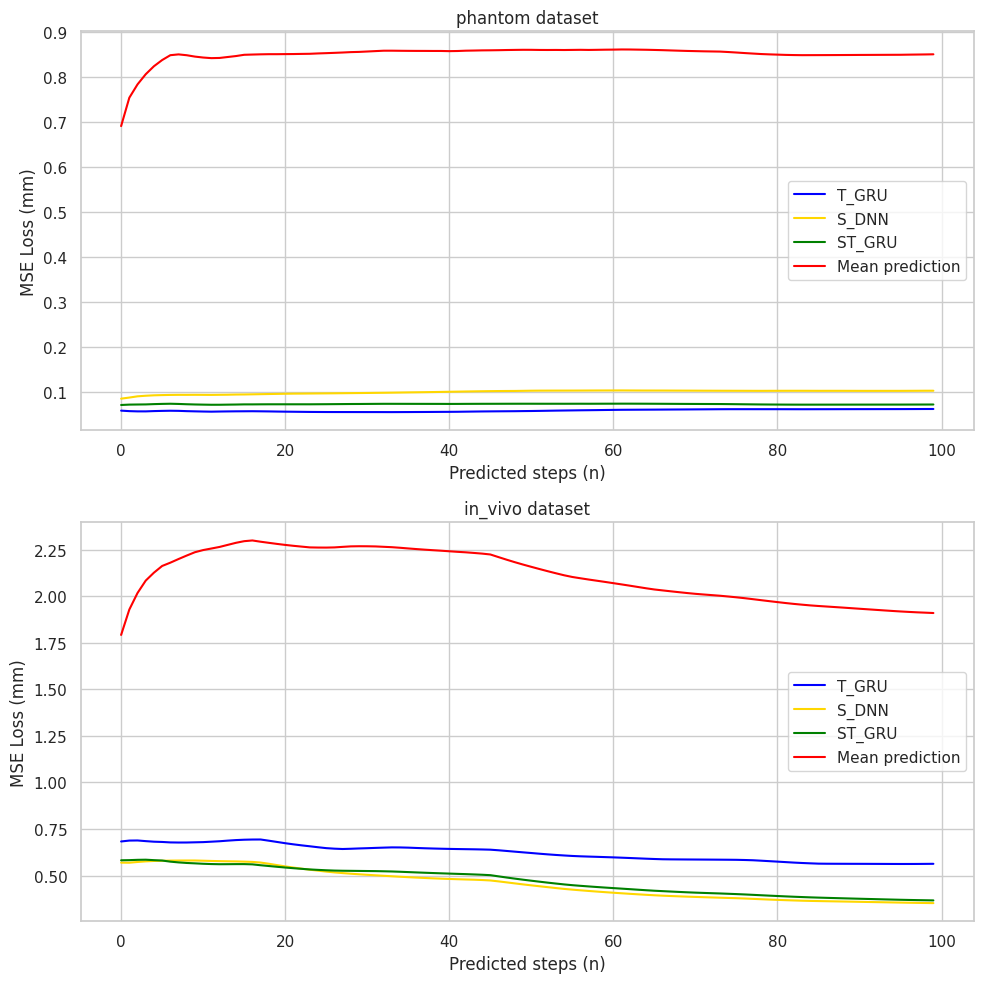

In [65]:
dataset_names = ["phantom", "in_vivo"]
colors = ["blue", "gold", "green", "red"]
models = ["T_GRU", "S_DNN", "ST_GRU"]
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

for i, dataset in enumerate(dataset_names):
    ax = axes[i]
    for j, model in enumerate(models):
        ax.plot(np.multiply(mean_info_array[j][0][i][:], 10), color=colors[j], label=f"{model}")
    ax.plot(np.multiply(mean_info_array[2][1][i][:],10), color=colors[j+1], label=f"Mean prediction")
    ax.set_title(f"{dataset} dataset")
    ax.legend()
    ax.set_ylabel("MSE Loss (mm)")
    ax.set_xlabel("Predicted steps (n)")

plt.tight_layout()

### Table 1: RMSE results on phantom and in vivo videos

RMSE values of T-GRU, S-DNN, TCN, ST-LSTM, ST-GRU in a 100-steps prediction (i.e. RMSE value at step 99) for the two datasets.

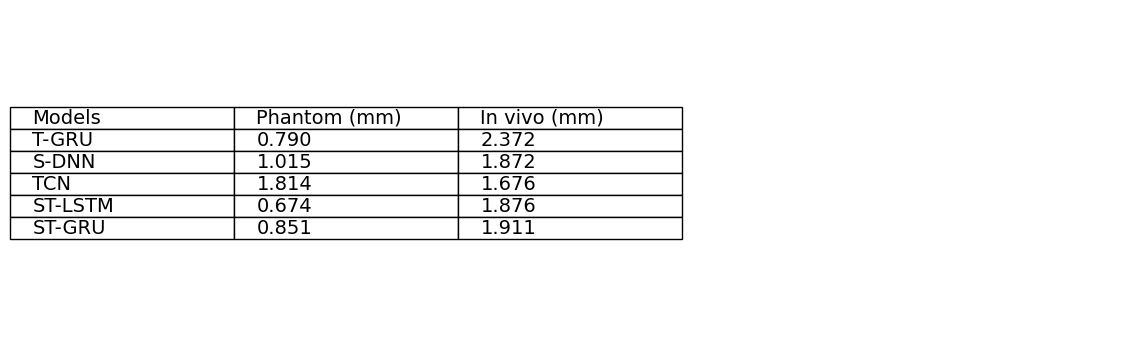

In [14]:

data = {
    'col_label': ['Models', 'Phantom (mm)', 'In vivo (mm)'],
    'Value': [
        ["T-GRU", format(mean_info_array[0, 1, 1]*10, ".3f"), format(mean_info_array[0, 1, 0]*10, ".3f")], 
        ["S-DNN", format(mean_info_array[1, 1, 1]*10, ".3f"), format(mean_info_array[1, 1, 0]*10, ".3f")],
        ["TCN", format(mean_info_array[3, 1, 1]*10, ".3f"), format(mean_info_array[3, 1, 0]*10, ".3f")], 
        ["ST-LSTM", format(mean_info_array[4, 1, 1]*10, ".3f"), format(mean_info_array[4, 1, 0]*10, ".3f")],
        ["ST-GRU", format(mean_info_array[2, 1, 1]*10, ".3f"), format(mean_info_array[2, 1, 0]*10, ".3f")],
        ]
}

fig, ax = plt.subplots()
ax.axis('off')
the_table = ax.table(cellText=data["Value"],
                     colLabels=data["col_label"],
                    cellLoc='left',
                    colLoc='left',
                    loc='left')

# Optionally, tweak the scaling of the table
plt.subplots_adjust(left=0.2, bottom=0.2)
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)
the_table.scale(1.5, 1.5)



### Table 2: RMSE under different noise variances in starting point on in vivo dataset

In [ ]:
model_paths = [
    "models_info/S_DNN_model_noise_stats.h5", 
    "models_info/T_GRU_model_noise_stats.h5", 
    "models_info/TCN_model_noise_stats.h5",
    "models_info/ST_LSTM_model_noise_stats.h5",
    "models_info/ST_GRU_model_noise_stats.h5",
    ]
noises = [0.0, 0.05, 0.2, 0.5, 1.0] # in centimeters
model_info_array = np.ndarray(shape=(len(model_paths), 2, 2, 5, 20, 50, 1))
mean_info_array = np.ndarray(shape=(len(model_paths), 2, 2))
for i, path in enumerate(model_paths):
    print(path)
    model_figure_info = load_data_noise_from_hdf5(path, "test_stats")
    for j, metric in enumerate(["MSE_loss", "RMSE_loss"]):
        for l, dataset in enumerate(["in_vivo", "phantom"]):
            for k, noise in enumerate(noises):
                for n, seed in enumerate(list(model_figure_info.keys())):
                    for m, start_idx in enumerate(range(50)):
                        model_info_array[i, j, l, k, n, m, 0] = model_figure_info[seed][dataset][str(noise)][str(start_idx)][metric]
mean_info_array = np.mean(model_info_array, axis=(4, 5, 6))

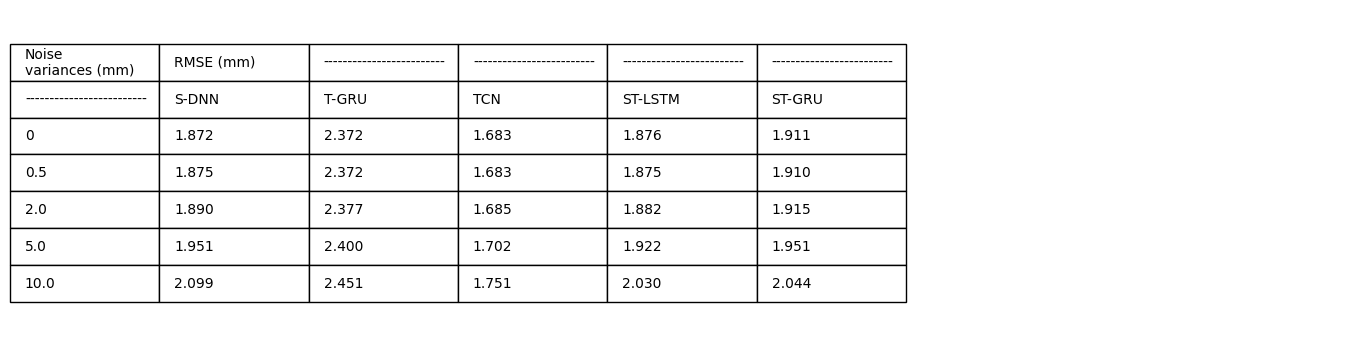

In [12]:

data = {
    'col_label': ['Noise\nvariances (mm)', 'RMSE (mm)', '-------------------------', '-------------------------', '-------------------------', '-------------------------'],
    'Value': [
        ["-------------------------", "S-DNN", "T-GRU", "TCN", "ST-LSTM", "ST-GRU"],
        ["0", format(mean_info_array[0, 1, 0, 0]*10, ".3f"), format(mean_info_array[1, 1, 0, 0]*10, ".3f"), format(mean_info_array[2, 1, 0, 0]*10, ".3f"), format(mean_info_array[3, 1, 0, 0]*10, ".3f"), format(mean_info_array[4, 1, 0, 0]*10, ".3f")], 
        ["0.5", format(mean_info_array[0, 1, 0, 1]*10, ".3f"), format(mean_info_array[1, 1, 0, 1]*10, ".3f"), format(mean_info_array[2, 1, 0, 1]*10, ".3f"), format(mean_info_array[3, 1, 0, 1]*10, ".3f"), format(mean_info_array[4, 1, 0, 1]*10, ".3f")],
        ["2.0", format(mean_info_array[0, 1, 0, 2]*10, ".3f"), format(mean_info_array[1, 1, 0, 2]*10, ".3f"), format(mean_info_array[2, 1, 0, 2]*10, ".3f"), format(mean_info_array[3, 1, 0, 2]*10, ".3f"), format(mean_info_array[4, 1, 0, 2]*10, ".3f")], 
        ["5.0", format(mean_info_array[0, 1, 0, 3]*10, ".3f"), format(mean_info_array[1, 1, 0, 3]*10, ".3f"), format(mean_info_array[2, 1, 0, 3]*10, ".3f"), format(mean_info_array[3, 1, 0, 3]*10, ".3f"), format(mean_info_array[4, 1, 0, 3]*10, ".3f"),],
        ["10.0", format(mean_info_array[0, 1, 0, 4]*10, ".3f"), format(mean_info_array[1, 1, 0, 4]*10, ".3f"), format(mean_info_array[2, 1, 0, 4]*10, ".3f"), format(mean_info_array[3, 1, 0, 4]*10, ".3f"), format(mean_info_array[4, 1, 0, 4]*10, ".3f"),],
        ]
}


fig, ax = plt.subplots()
ax.axis('off')
the_table = ax.table(cellText=data["Value"],
                     colLabels=data["col_label"],
                    cellLoc='left',
                    colLoc='left',
                    loc='left')

# Optionally, tweak the scaling of the table
plt.subplots_adjust(left=0.2, bottom=0.2)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(2, 2.5)

### Fig. 6. Motion predicted curve of y-axis on three models with noise at 621st time step.

In [ ]:
model_paths = [
    "models_info/S_DNN_model_noise_21_stats.h5", 
    "models_info/T_GRU_model_noise_21_stats.h5", 
    "models_info/ST_GRU_model_noise_21_stats.h5",
    ]

model_info_array = np.ndarray(shape=(len(model_paths), 2, 3, 100, 20, 1))
mean_info_array = np.ndarray(shape=(len(model_paths), 2, 2))
for p, path in enumerate(model_paths):
    model_figure_info = load_data_from_hdf5(path, "test_stats")
    for d, dataset in enumerate(["phantom", "in_vivo"]):
        for axe in range(3):
            for cycle in range(100):
                for s, seed in enumerate(list(model_figure_info.keys())):
                    for start_idx in [0]:
                        model_info_array[p, d, axe, cycle, s, start_idx] = model_figure_info[seed][dataset][str(start_idx)]["preds_test_scaled"][cycle][axe]
mean_info_array = np.mean(model_info_array, axis=(4, 5))


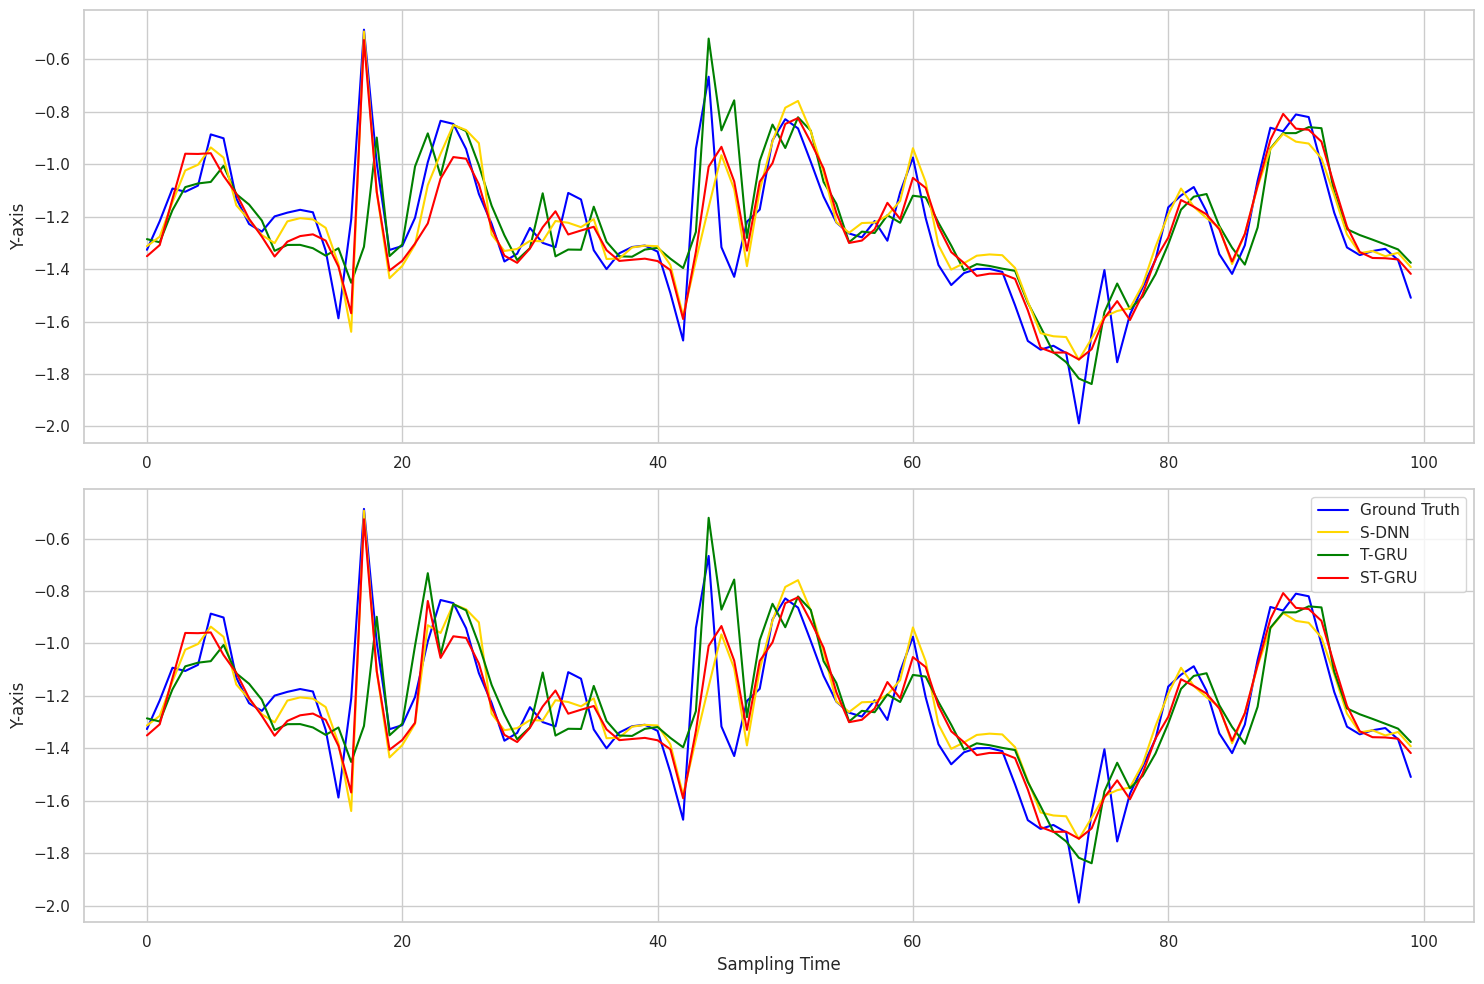

In [47]:
# T-GRU - S-DNN - ST-GRU => x - y - z / steps

sns.set_theme(style="whitegrid")

ground_truths_test = in_vivo_dataset

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

axes[0].plot(ground_truths_test[1,:], color = "blue")
axes[0].plot(dataset_positions_T[0][1], color = "green")
axes[0].plot(dataset_positions_S[0][1], color = "gold")
axes[0].plot(dataset_positions_ST[0][1], color = "red") 
axes[0].set_ylabel("Y-axis")

axes[1].plot(ground_truths_test[1,:], color = "blue", label="Ground Truth")
axes[1].plot(mean_info_array[0, 1, 1,:], color = "gold", label="S-DNN")
axes[1].plot(mean_info_array[1, 1, 1,:], color = "green", label="T-GRU")
axes[1].plot(mean_info_array[2, 1, 1,:], color = "red", label="ST-GRU")
axes[1].set_ylabel("Y-axis")
axes[1].set_xlabel("Sampling Time")

plt.legend()
plt.tight_layout()

### Fig. 7. Average MSE curves $\overline{l}(n)$ with a random noise added at 621th step.

In [ ]:
model_paths = [
    "models_info/T_GRU_model_noise_21_stats.h5", 
    "models_info/ST_GRU_model_noise_21_stats.h5",
    "models_info/S_DNN_model_noise_21_stats.h5", 
    "models_info/TCN_model_noise_21_stats.h5",
    "models_info/ST_LSTM_model_noise_21_stats.h5",
    ]
model_info_array = np.ndarray(shape=(len(model_paths), 2, 2, 20, 50, 100, 1))
mean_info_array = np.ndarray(shape=(len(model_paths), 2, 2))
for i, path in enumerate(model_paths):
    model_figure_info = load_data_from_hdf5(path, "test_stats")
    for j, metric in enumerate(["MSE_loss", "RMSE_loss"]):
        for l, dataset in enumerate(["phantom", "in_vivo"]):
            for n, seed in enumerate(list(model_figure_info.keys())):
                for m, start_idx in enumerate(range(50)):
                    for k in range(100):
                        if (i == 3 and k > 95):
                            model_info_array[i, j, l, n, m, k, 0] = model_figure_info[seed][dataset][str(start_idx)][metric][-1]
                        else:
                            model_info_array[i, j, l, n, m, k, 0] = model_figure_info[seed][dataset][str(start_idx)][metric][k]
                            
mean_info_array = np.mean(model_info_array[:,:,:,:,:,:,0], axis=(3, 4))

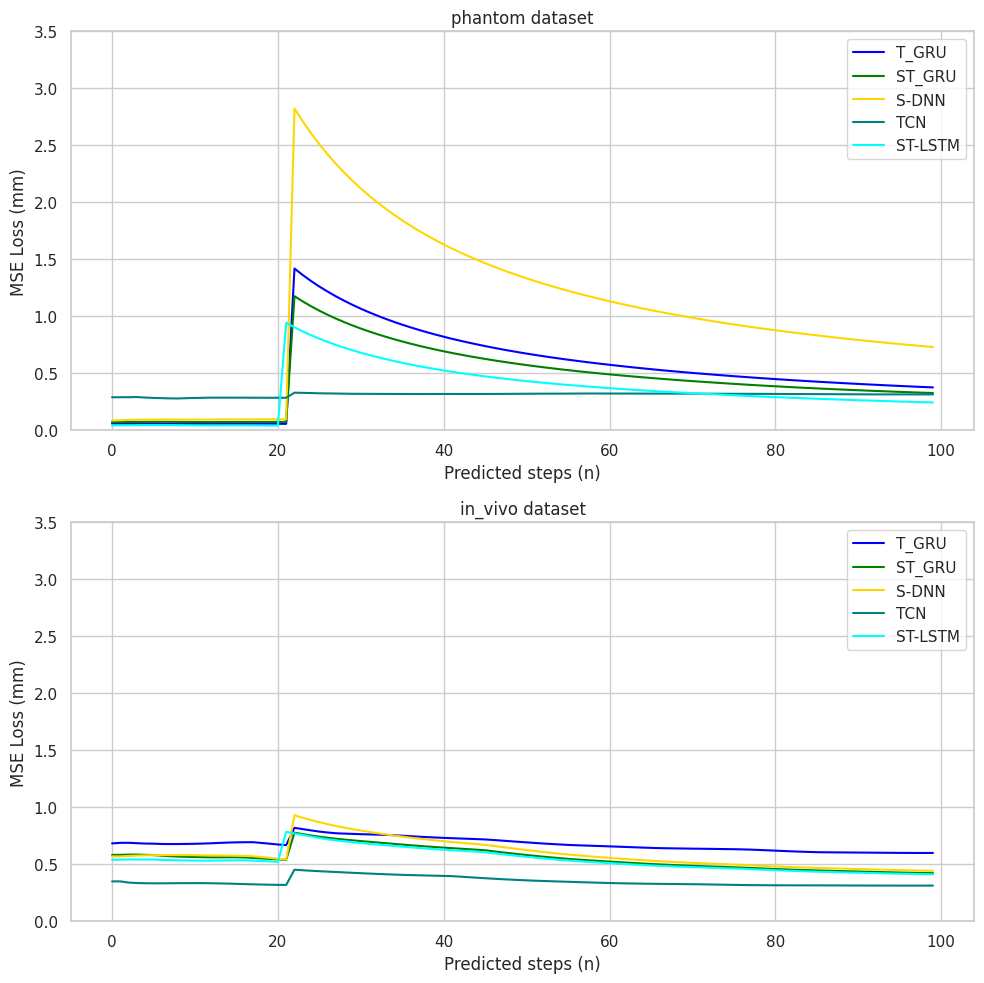

In [24]:
dataset_names = ["phantom", "in_vivo"]
colors = ["blue",  "green", "gold", "teal", "cyan"]
models = ["T_GRU", "ST_GRU", "S-DNN", "TCN", "ST-LSTM"]
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

for i, dataset in enumerate(dataset_names):
    ax = axes[i]
    for j, model in enumerate(models):
        ax.plot(np.multiply(mean_info_array[j][0][i][:], 10), color=colors[j], label=f"{model}")
    #ax.plot(np.multiply(mean_info_array[2][1][i][:],10), color=colors[j+1], label=f"Mean prediction")
    ax.set_title(f"{dataset} dataset")
    ax.legend()
    ax.set_ylabel("MSE Loss (mm)")
    ax.set_xlabel("Predicted steps (n)")
    ax.set_ylim(0, 3.5)

plt.tight_layout()